In [1]:
pip install pandas numpy matplotlib seaborn scipy 

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd 
activity = pd.read_csv("/mnt/disk15tb/ammara/AR_Media Density_T3_07012025_All Files/ActivityScan_outputs/Compiled_Activity_Summary.csv")
activity

,Run_ID,AssayType,DIV,Well,NeuronType,Time,Chip_ID,Mean_FiringRate,Mean_SpikeAmplitude,Active_area,Mean_ISI,Std_ISI,Mean_ISI_CV,Mean_Fano
0,6,Sparse7x,3,3,100K NBP,04-Jul-2025 09:52:26,M07037,1.477333,35.040226,0.378788,5.215168,2.211950,1.274626,1.356341
1,6,Sparse7x,3,6,80K NBP,04-Jul-2025 09:52:26,M07037,0.611111,34.062594,0.227273,5.812824,2.305617,1.184606,1.166302
2,12,Sparse7x,3,2,80K NBP,04-Jul-2025 10:31:11,M07137,1.145035,44.202583,1.424242,3.812263,2.503176,1.143892,1.412134
3,12,Sparse7x,3,4,120K NBP,04-Jul-2025 10:31:11,M07137,1.033333,47.968528,1.378788,3.894689,2.244279,1.135744,1.401418
4,12,Sparse7x,3,5,100K NBP,04-Jul-2025 10:31:11,M07137,0.899216,43.599872,1.287879,3.663757,2.656026,1.114812,1.359295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,209,Full Scan 30s,27,2,80K NBP,28-Jul-2025 09:43:46,M08024,3.296484,84.844495,71.325758,1.635891,1.516908,2.099009,5.964516
140,209,Full Scan 30s,27,4,120K NBP,28-Jul-2025 09:43:46,M08024,1.583740,83.402519,73.537879,2.690711,2.203659,1.598842,3.564393
141,209,Full Scan 30s,27,6,120K NBP,28-Jul-2025 09:43:46,M08024,2.379139,81.589740,71.886364,2.202581,2.251036,2.504290,6.195119
142,219,Full Scan 30s,27,3,100K NBP,28-Jul-2025 10:57:42,M08028,0.341667,35.233094,0.030303,8.327665,5.580620,0.791335,1.015785


In [6]:
pip install pandas numpy matplotlib seaborn scipy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 64.0 MB/s  0:00:00 eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


Loaded 68 measurements
Media types: ['DMEM' 'NBP']
Densities: ['100K', '120K', '80K']
DIV range: 5 - 29

🎨 Generating visualizations with statistical analysis...
✅ Saved: firing_rate_comparison.png


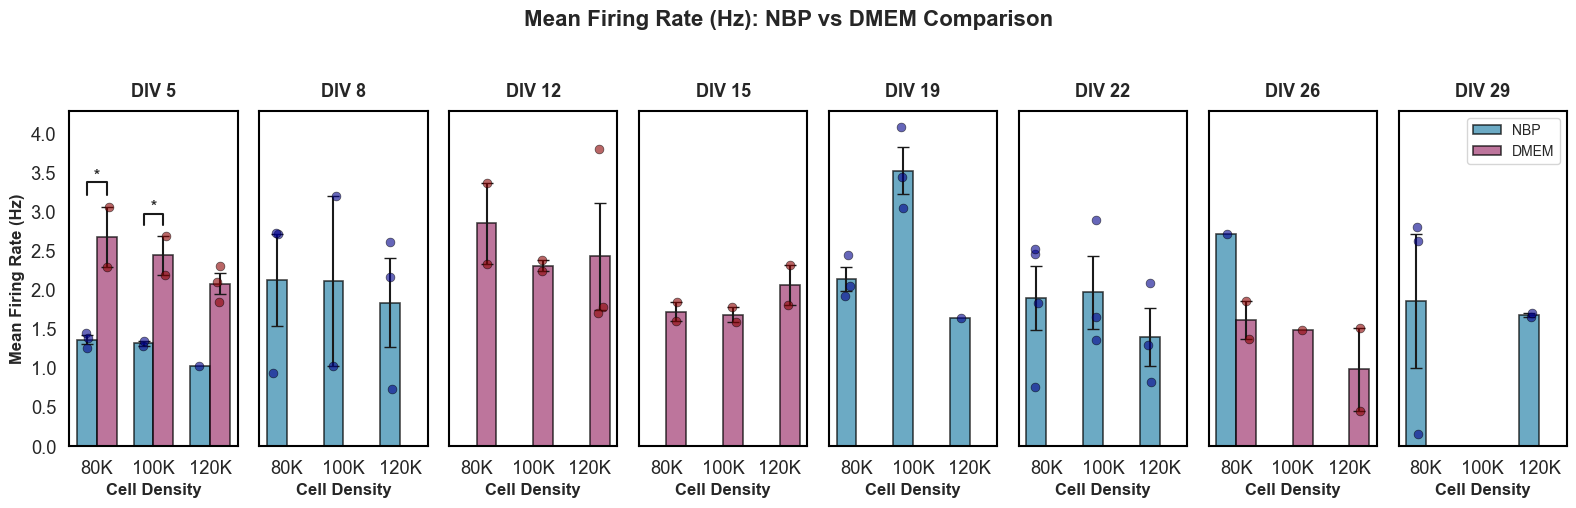

✅ Saved: amplitude_comparison.png


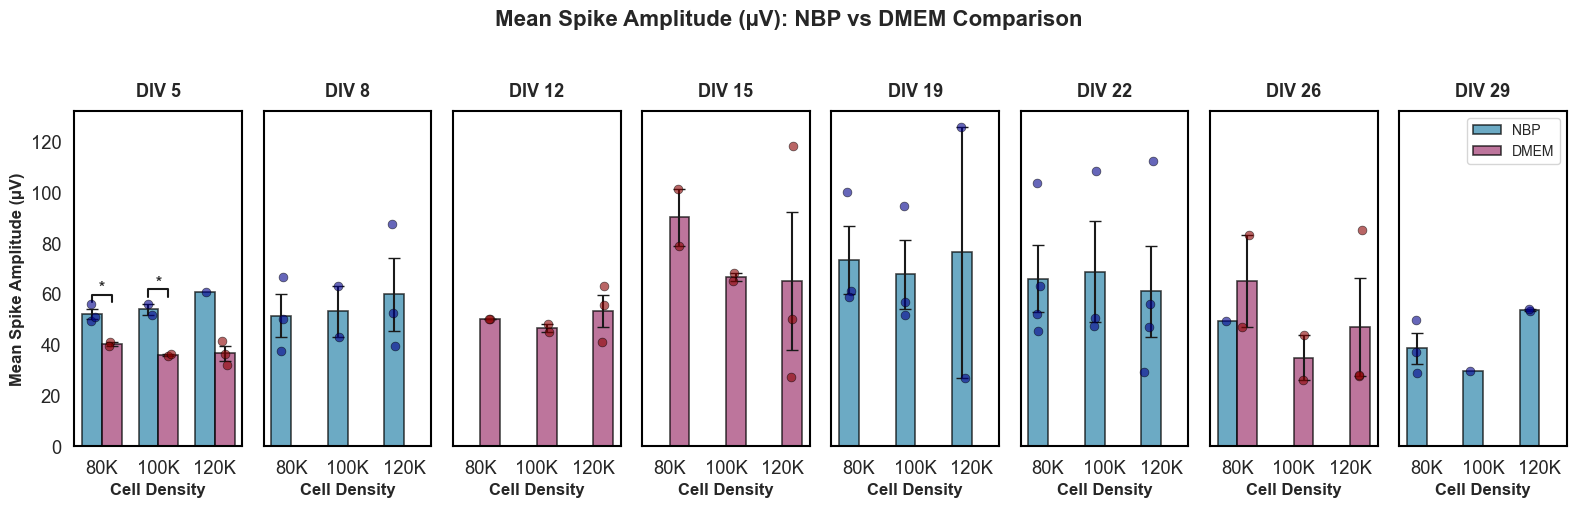

✅ Saved: active_area_comparison.png


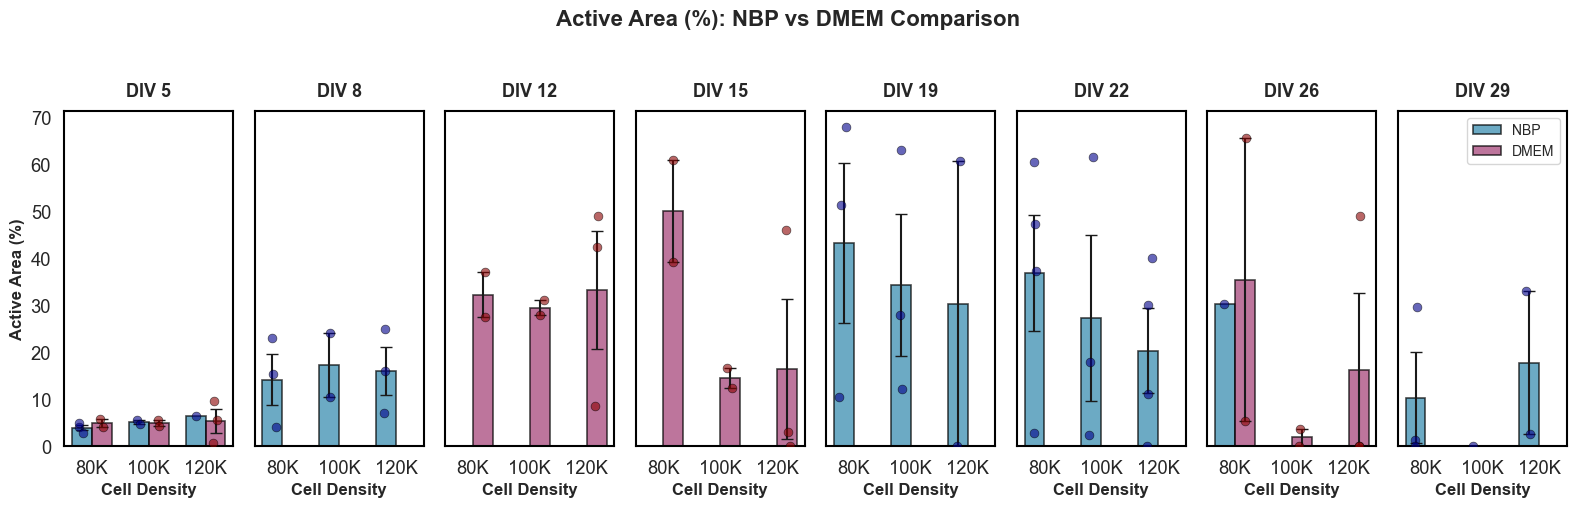

✅ Saved: firing_rate_trends.png


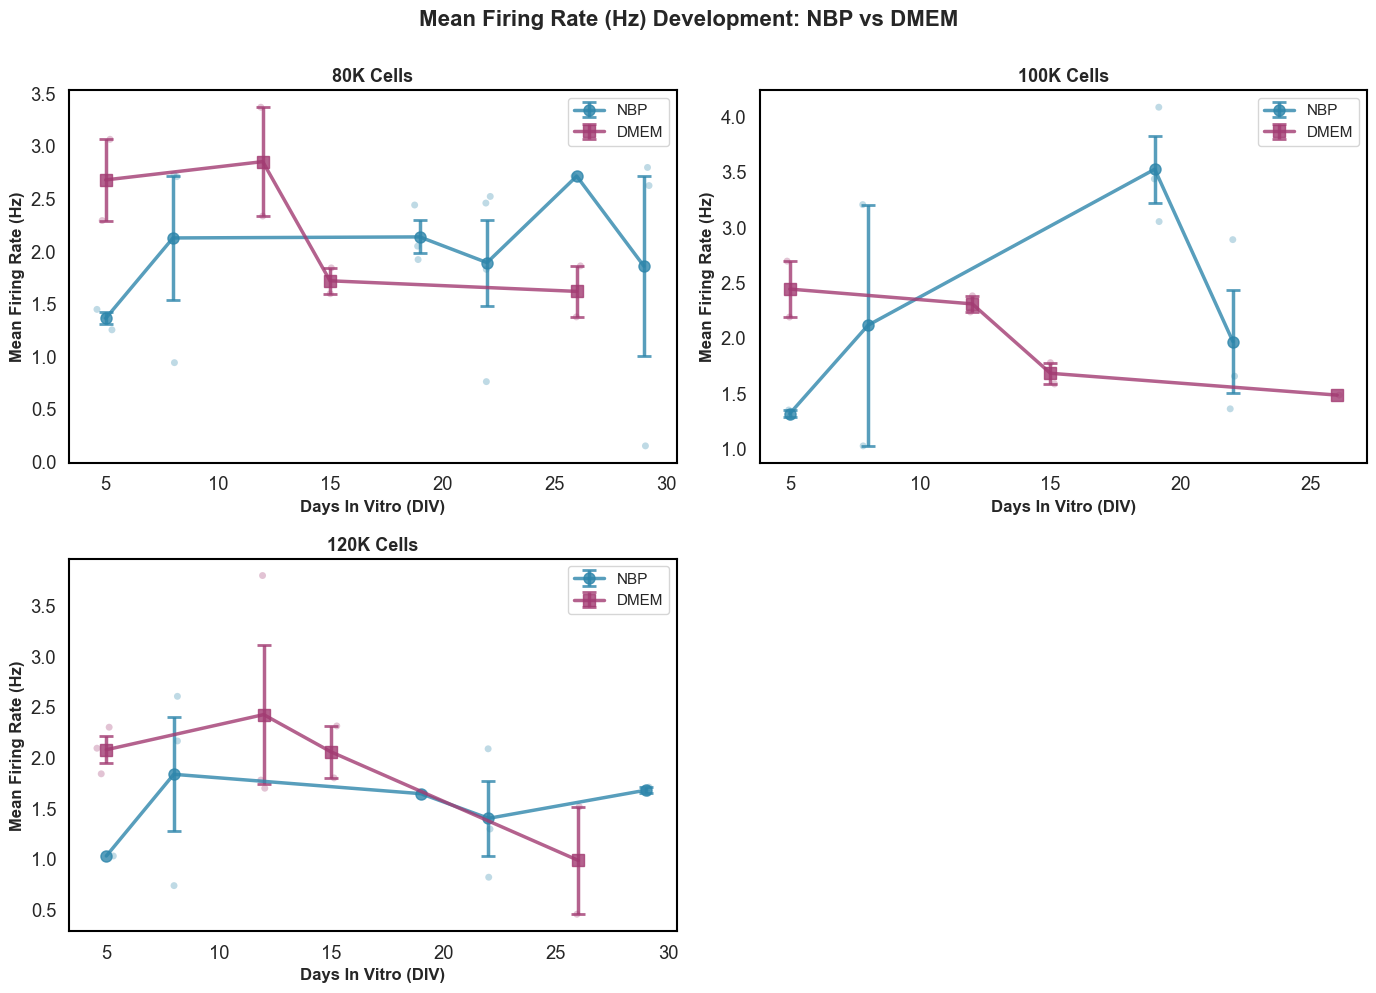

✅ Saved: active_area_trends.png


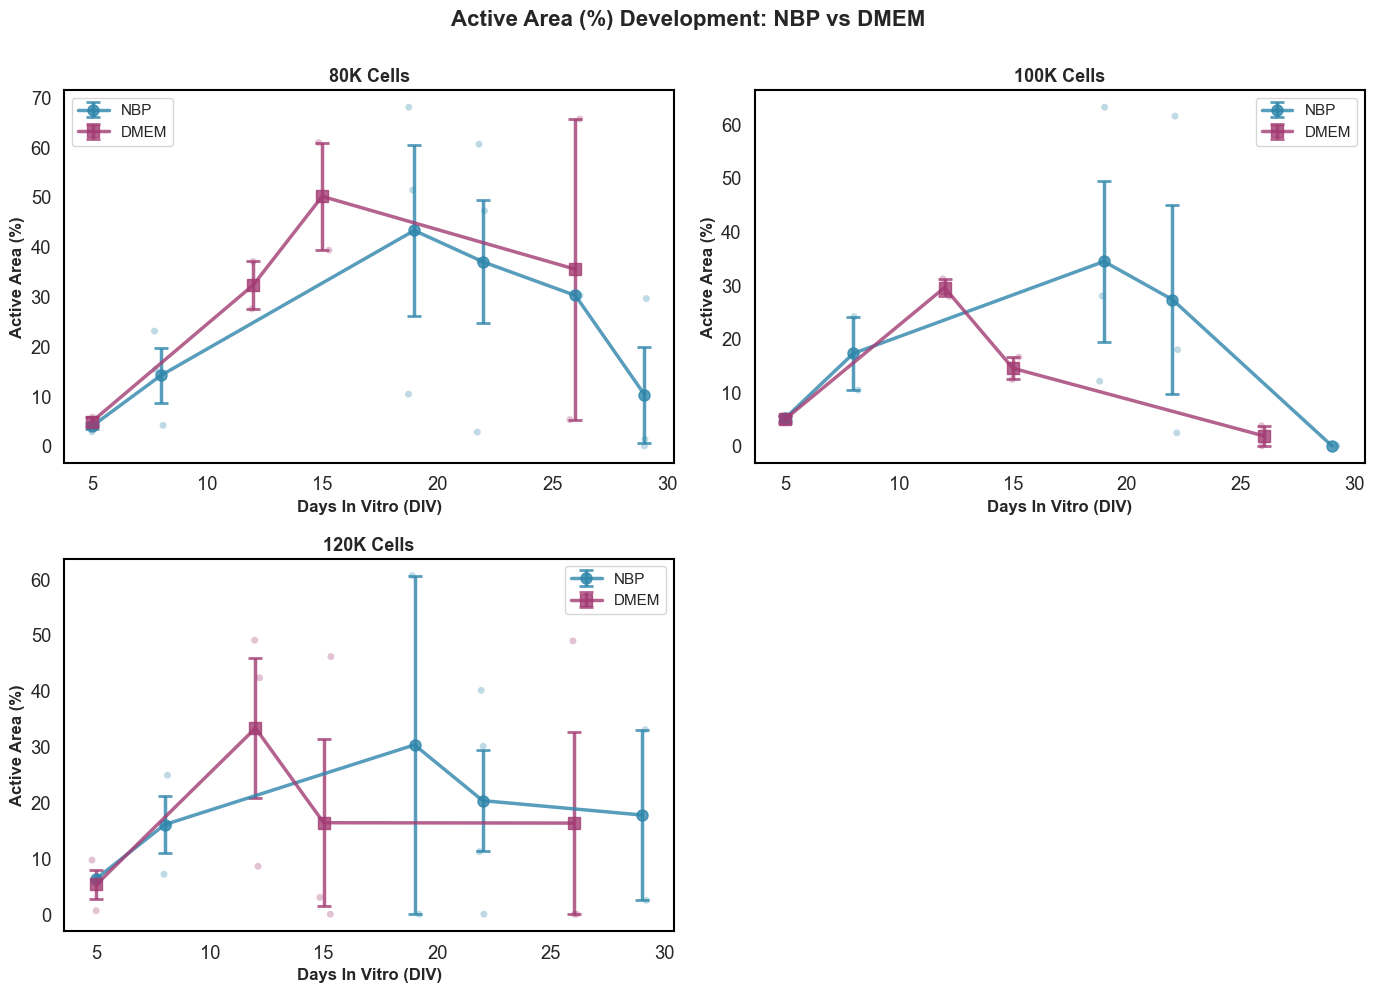

✅ Saved: dashboard_DIV29.png
✅ Saved: dashboard_overall.png

✅ All plots generated successfully and saved to /mnt/disk15tb/shruti/MediaDensityT4/ActivityOutputs

Statistical significance key:
  ns   : p > 0.05 (Not significant)
  *    : p ≤ 0.05 (Significant)
  **   : p ≤ 0.01 (Very significant)
  ***  : p ≤ 0.001 (Highly significant)
  **** : p ≤ 0.0001 (Extremely significant)


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import os
warnings.filterwarnings('ignore')

# =====================================
# 1️⃣ DATA LOADING & PREPROCESSING
# =====================================
def load_and_process_data(csv_path):
    """Load MEA data and extract media type and density"""
    df = pd.read_csv(csv_path)
    
    # Extract media type (NBP or DMEM) and density from NeuronType
    df['Media'] = df['NeuronType'].str.extract(r'(NBP|DMEM)')[0]
    df['Density'] = df['NeuronType'].str.extract(r'(\d+K)')[0]
    
    # Convert to numeric where needed
    df['DIV'] = df['DIV'].astype(int)
    df['Chip_ID'] = df['Chip_ID'].astype(str)
    df['Well'] = df['Well'].astype(str)
    
    # Create unique well identifier
    df['CHIP_WELL'] = df['Chip_ID'] + '_' + df['Well']
    
    # Drop rows with missing media or density info
    df = df.dropna(subset=['Media', 'Density'])
    
    print(f"Loaded {len(df)} measurements")
    print(f"Media types: {df['Media'].unique()}")
    print(f"Densities: {sorted(df['Density'].unique())}")
    print(f"DIV range: {df['DIV'].min()} - {df['DIV'].max()}")
    
    return df


# =====================================
# 2️⃣ STATISTICAL TESTING HELPER
# =====================================
def get_significance_stars(p_value):
    """Convert p-value to significance stars"""
    if p_value <= 0.0001:
        return '****'
    elif p_value <= 0.001:
        return '***'
    elif p_value <= 0.01:
        return '**'
    elif p_value <= 0.05:
        return '*'
    else:
        return 'ns'

def add_stat_annotation(ax, x1, x2, y, p_value, bar_width=0.35):
    """Add statistical significance annotation to bar plot"""
    stars = get_significance_stars(p_value)
    
    # Calculate positions
    x_center = (x1 + x2) / 2
    
    # Draw bracket
    bracket_height = y * 0.05  # 5% above the bars
    ax.plot([x1, x1, x2, x2], 
            [y, y + bracket_height, y + bracket_height, y], 
            'k-', linewidth=1.5)
    
    # Add stars/ns
    ax.text(x_center, y + bracket_height, stars, 
            ha='center', va='bottom', fontsize=11, weight='bold')


# =====================================
# 3️⃣ BAR PLOTS WITH STATISTICS
# =====================================
def plot_comparison_bars(df, metric='Mean_FiringRate', title=None, save_path=None):
    """Create bar plot comparing NBP vs DMEM across densities with statistics"""
    
    # Set up the plot
    fig, axes = plt.subplots(1, len(df['DIV'].unique()), figsize=(16, 5), sharey=True)
    if len(df['DIV'].unique()) == 1:
        axes = [axes]
    
    # Color palette
    colors = {'NBP': '#2E86AB', 'DMEM': '#A23B72'}
    
    # Get sorted densities
    densities = sorted(df['Density'].unique(), key=lambda x: int(x.replace('K', '')))
    divs = sorted(df['DIV'].unique())
    
    # Metric label
    metric_labels = {
        'Mean_FiringRate': 'Mean Firing Rate (Hz)',
        'Mean_SpikeAmplitude': 'Mean Spike Amplitude (µV)',
        'Active_area': 'Active Area (%)',
        'Mean_ISI': 'Mean ISI (s)',
        'Mean_ISI_CV': 'ISI Coefficient of Variation',
        'Mean_Fano': 'Fano Factor'
    }
    ylabel = metric_labels.get(metric, metric)
    
    for idx, div in enumerate(divs):
        ax = axes[idx]
        div_data = df[df['DIV'] == div]
        
        # Prepare data for plotting
        x_pos = np.arange(len(densities))
        bar_width = 0.35
        
        nbp_means = []
        nbp_sems = []
        dmem_means = []
        dmem_sems = []
        p_values = []
        max_heights = []
        
        for density in densities:
            nbp_vals = div_data[(div_data['Media'] == 'NBP') & 
                                (div_data['Density'] == density)][metric].dropna()
            dmem_vals = div_data[(div_data['Media'] == 'DMEM') & 
                                 (div_data['Density'] == density)][metric].dropna()
            
            nbp_means.append(nbp_vals.mean() if len(nbp_vals) > 0 else 0)
            nbp_sems.append(nbp_vals.sem() if len(nbp_vals) > 0 else 0)
            dmem_means.append(dmem_vals.mean() if len(dmem_vals) > 0 else 0)
            dmem_sems.append(dmem_vals.sem() if len(dmem_vals) > 0 else 0)
            
            # Perform t-test
            if len(nbp_vals) >= 2 and len(dmem_vals) >= 2:
                t_stat, p_val = stats.ttest_ind(nbp_vals, dmem_vals)
                p_values.append(p_val)
            else:
                p_values.append(1.0)  # Not significant if insufficient data
            
            # Track max height for annotation placement
            max_heights.append(max(nbp_means[-1] + nbp_sems[-1], 
                                  dmem_means[-1] + dmem_sems[-1]))
        
        # Plot bars
        bars1 = ax.bar(x_pos - bar_width/2, nbp_means, bar_width, 
                       yerr=nbp_sems, label='NBP', color=colors['NBP'], 
                       alpha=0.7, capsize=4, edgecolor='black', linewidth=1.2)
        bars2 = ax.bar(x_pos + bar_width/2, dmem_means, bar_width,
                       yerr=dmem_sems, label='DMEM', color=colors['DMEM'],
                       alpha=0.7, capsize=4, edgecolor='black', linewidth=1.2)
        
        # Overlay individual data points
        for i, density in enumerate(densities):
            nbp_vals = div_data[(div_data['Media'] == 'NBP') & 
                                (div_data['Density'] == density)][metric].dropna()
            dmem_vals = div_data[(div_data['Media'] == 'DMEM') & 
                                 (div_data['Density'] == density)][metric].dropna()
            
            # Add jitter to x-position
            if len(nbp_vals) > 0:
                x_jitter = np.random.normal(i - bar_width/2, 0.03, len(nbp_vals))
                ax.scatter(x_jitter, nbp_vals, color='darkblue', 
                          s=40, alpha=0.6, edgecolor='black', linewidth=0.5, zorder=3)
            
            if len(dmem_vals) > 0:
                x_jitter = np.random.normal(i + bar_width/2, 0.03, len(dmem_vals))
                ax.scatter(x_jitter, dmem_vals, color='darkred',
                          s=40, alpha=0.6, edgecolor='black', linewidth=0.5, zorder=3)
        
        # Add statistical annotations
        for i, (density, p_val, max_h) in enumerate(zip(densities, p_values, max_heights)):
            if p_val < 0.05:  # Only show if significant
                add_stat_annotation(ax, 
                                   i - bar_width/2, 
                                   i + bar_width/2, 
                                   max_h * 1.05, 
                                   p_val, 
                                   bar_width)
        
        # Formatting
        ax.set_xlabel('Cell Density', fontsize=12, weight='bold')
        if idx == 0:
            ax.set_ylabel(ylabel, fontsize=12, weight='bold')
        ax.set_title(f'DIV {div}', fontsize=13, weight='bold', pad=10)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(densities, rotation=0)
        ax.grid(False)
        for spine in ['top', 'bottom', 'left', 'right']:
            ax.spines[spine].set_visible(True)
            ax.spines[spine].set_color('black')
            ax.spines[spine].set_linewidth(1.5)

        # Adjust y-limit to accommodate annotations
        #current_ylim = ax.get_ylim()
        #ax.set_ylim(current_ylim[0], current_ylim[1] * 1.15)
        
        #if idx == len(divs) - 1:
           # ax.legend(frameon=False, fontsize=10, loc='upper right')
    
    # Overall title
    if title is None:
        title = f'{ylabel}: NBP vs DMEM Comparison'
    fig.suptitle(title, fontsize=16, weight='bold', y=1.02)
    # Add legend to the last subplot
    if idx == len(divs) - 1:
        ax.legend(frameon=True, fontsize=10, loc='upper right')
    plt.tight_layout()
    if save_path:
        try:
            # Try to remove existing file first
            if os.path.exists(save_path):
                os.chmod(save_path, 0o666)  # Make writable
                os.remove(save_path)
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            os.chmod(save_path, 0o666)  # Make file accessible
            print(f"✅ Saved: {os.path.basename(save_path)}")
        except PermissionError:
            # If permission denied, try with timestamp
            timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
            new_path = save_path.replace('.png', f'_{timestamp}.png')
            plt.savefig(new_path, dpi=300, bbox_inches='tight')
            print(f"⚠️  Permission denied for {save_path}, Try with timestamp")
            print(f"✅ Saved instead to: {new_path}")
        # Show the plot in the notebook
        plt.show()
        plt.close(fig)
    else:
        plt.show()


# =====================================
# 4️⃣ TREND LINES ACROSS DIVs
# =====================================
def plot_developmental_trends(df, metric='Mean_FiringRate', save_path=None):
    """Plot developmental trajectories for NBP vs DMEM at each density"""
    
    densities = sorted(df['Density'].unique(), key=lambda x: int(x.replace('K', '')))
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    colors = {'NBP': '#2E86AB', 'DMEM': '#A23B72'}
    markers = {'NBP': 'o', 'DMEM': 's'}
    
    metric_labels = {
        'Mean_FiringRate': 'Mean Firing Rate (Hz)',
        'Mean_SpikeAmplitude': 'Mean Spike Amplitude (µV)',
        'Active_area': 'Active Area (%)',
        'Mean_ISI': 'Mean ISI (s)'
    }
    ylabel = metric_labels.get(metric, metric)
    
    for idx, density in enumerate(densities):
        if idx >= len(axes):
            break
        
        ax = axes[idx]
        density_data = df[df['Density'] == density]
        
        for media in ['NBP', 'DMEM']:
            media_data = density_data[density_data['Media'] == media]
            
            # Calculate mean and SEM per DIV
            summary = media_data.groupby('DIV')[metric].agg(['mean', 'sem', 'count'])
            divs = summary.index.values
            means = summary['mean'].values
            sems = summary['sem'].values
            
            # Plot line with error bars
            ax.errorbar(divs, means, yerr=sems, 
                       label=media, color=colors[media], 
                       marker=markers[media], markersize=8,
                       linewidth=2.5, capsize=5, capthick=2, alpha=0.8)
            
            # Add individual points with jitter
            for div in divs:
                div_vals = media_data[media_data['DIV'] == div][metric].dropna()
                if len(div_vals) > 0:
                    jitter = np.random.normal(0, 0.15, len(div_vals))
                    ax.scatter(div + jitter, div_vals, 
                             color=colors[media], alpha=0.3, s=25, edgecolor='none')
        
        ax.set_xlabel('Days In Vitro (DIV)', fontsize=12, weight='bold')
        ax.set_ylabel(ylabel, fontsize=12, weight='bold')
        ax.set_title(f'{density} Cells', fontsize=13, weight='bold')
        ax.legend(frameon=True, fontsize=11)
        ax.grid(False)
        # Turn on full frame (all 4 spines)
        for spine in ['top', 'bottom', 'left', 'right']:
            ax.spines[spine].set_visible(True)
            ax.spines[spine].set_color('black')
            ax.spines[spine].set_linewidth(1.5)

    # Hide extra subplots if fewer than 4 densities
    for idx in range(len(densities), len(axes)):
        axes[idx].set_visible(False)
    
    fig.suptitle(f'{ylabel} Development: NBP vs DMEM', 
                 fontsize=16, weight='bold', y=0.995)
    plt.tight_layout()
    
    if save_path:
        try:
            if os.path.exists(save_path):
                os.chmod(save_path, 0o666)
                os.remove(save_path)
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            os.chmod(save_path, 0o666)
            print(f"✅ Saved: {os.path.basename(save_path)}")
        except PermissionError:
            timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
            new_path = save_path.replace('.png', f'_{timestamp}.png')
            plt.savefig(new_path, dpi=300, bbox_inches='tight')
            print(f"⚠️  Permission denied for {save_path}")
            print(f"✅ Saved instead to: {new_path}")
        plt.show()
        plt.close(fig)
    else:
        plt.show()


# =====================================
# 5️⃣ MULTI-METRIC DASHBOARD WITH STATISTICS
# =====================================
def plot_multi_metric_dashboard(df, div=None, save_path=None):
    """Create a dashboard with multiple metrics comparing NBP vs DMEM with statistics"""
    
    if div is not None:
        df = df[df['DIV'] == div].copy()
        title_suffix = f'at DIV {div}'
    else:
        title_suffix = 'across all DIVs'
    
    metrics = ['Mean_FiringRate', 'Mean_SpikeAmplitude', 'Active_area', 'Mean_ISI_CV']
    metric_labels = {
        'Mean_FiringRate': 'Firing Rate (Hz)',
        'Mean_SpikeAmplitude': 'Spike Amplitude (µV)',
        'Active_area': 'Active Area (%)',
        'Mean_ISI_CV': 'ISI CV'
    }
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    colors = {'NBP': '#2E86AB', 'DMEM': '#A23B72'}
    densities = sorted(df['Density'].unique(), key=lambda x: int(x.replace('K', '')))
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx]
        x_pos = np.arange(len(densities))
        bar_width = 0.35
        
        nbp_means = []
        nbp_sems = []
        dmem_means = []
        dmem_sems = []
        p_values = []
        max_heights = []
        
        for density in densities:
            nbp_vals = df[(df['Media'] == 'NBP') & (df['Density'] == density)][metric].dropna()
            dmem_vals = df[(df['Media'] == 'DMEM') & (df['Density'] == density)][metric].dropna()
            
            nbp_means.append(nbp_vals.mean() if len(nbp_vals) > 0 else 0)
            nbp_sems.append(nbp_vals.sem() if len(nbp_vals) > 0 else 0)
            dmem_means.append(dmem_vals.mean() if len(dmem_vals) > 0 else 0)
            dmem_sems.append(dmem_vals.sem() if len(dmem_vals) > 0 else 0)
            
            # Perform t-test
            if len(nbp_vals) >= 2 and len(dmem_vals) >= 2:
                t_stat, p_val = stats.ttest_ind(nbp_vals, dmem_vals)
                p_values.append(p_val)
            else:
                p_values.append(1.0)
            
            max_heights.append(max(nbp_means[-1] + nbp_sems[-1], 
                                  dmem_means[-1] + dmem_sems[-1]))
        
        # Bars
        ax.bar(x_pos - bar_width/2, nbp_means, bar_width, 
               yerr=nbp_sems, label='NBP', color=colors['NBP'], 
               alpha=0.7, capsize=4, edgecolor='black', linewidth=1.2)
        ax.bar(x_pos + bar_width/2, dmem_means, bar_width,
               yerr=dmem_sems, label='DMEM', color=colors['DMEM'],
               alpha=0.7, capsize=4, edgecolor='black', linewidth=1.2)
        
        # Individual points
        for i, density in enumerate(densities):
            nbp_vals = df[(df['Media'] == 'NBP') & (df['Density'] == density)][metric].dropna()
            dmem_vals = df[(df['Media'] == 'DMEM') & (df['Density'] == density)][metric].dropna()
            
            if len(nbp_vals) > 0:
                x_jitter = np.random.normal(i - bar_width/2, 0.03, len(nbp_vals))
                ax.scatter(x_jitter, nbp_vals, color='darkblue', 
                          s=35, alpha=0.6, edgecolor='black', linewidth=0.5, zorder=3)
            
            if len(dmem_vals) > 0:
                x_jitter = np.random.normal(i + bar_width/2, 0.03, len(dmem_vals))
                ax.scatter(x_jitter, dmem_vals, color='darkred',
                          s=35, alpha=0.6, edgecolor='black', linewidth=0.5, zorder=3)
        
        # Add statistical annotations
        for i, (density, p_val, max_h) in enumerate(zip(densities, p_values, max_heights)):
            if p_val < 0.05:
                add_stat_annotation(ax, 
                                   i - bar_width/2, 
                                   i + bar_width/2, 
                                   max_h * 1.05, 
                                   p_val, 
                                   bar_width)
        
        ax.set_xlabel('Cell Density', fontsize=11, weight='bold')
        ax.set_ylabel(metric_labels[metric], fontsize=11, weight='bold')
        ax.set_title(metric_labels[metric], fontsize=12, weight='bold', pad=8)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(densities)
        ax.grid(False)
        for spine in ['top', 'bottom', 'left', 'right']:
            ax.spines[spine].set_visible(True)
            ax.spines[spine].set_color('black')
            ax.spines[spine].set_linewidth(1.5)

        
        # Adjust y-limit
        current_ylim = ax.get_ylim()
        if metric == 'Active_area':
            ax.set_ylim(0, min(105, current_ylim[1] * 1.15))
        else:
            ax.set_ylim(current_ylim[0], current_ylim[1] * 1.15)
        
        if idx == 1:
            ax.legend(frameon=True, fontsize=10, loc='upper right')
    
    plt.tight_layout()
    
    if save_path:
        try:
            if os.path.exists(save_path):
                os.chmod(save_path, 0o666)
                os.remove(save_path)
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            os.chmod(save_path, 0o666)
            print(f"✅ Saved: {os.path.basename(save_path)}")
        except PermissionError:
            timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
            new_path = save_path.replace('.png', f'_{timestamp}.png')
            plt.savefig(new_path, dpi=300, bbox_inches='tight')
            print(f"⚠️  Permission denied for {save_path}")
            print(f"✅ Saved instead to: {new_path}")
        finally:
            plt.close(fig)
    else:
        plt.show()


# =====================================
# 6️⃣ MAIN EXECUTION
# =====================================
if __name__ == "__main__":
    # Load data
    csv_path = "/mnt/disk15tb/shruti/MediaDensityT4/ActivityScan_outputs/Compiled_Activity_Summary.csv"
    output_dir = "/mnt/disk15tb/shruti/MediaDensityT4/ActivityOutputs"
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    df = load_and_process_data(csv_path)
    
    print("\n🎨 Generating visualizations with statistical analysis...")
    
    # 1. Bar plots for each DIV - Mean Firing Rate
    plot_comparison_bars(df, metric='Mean_FiringRate', 
                        save_path=f'{output_dir}/firing_rate_comparison.png')
    
    # 2. Bar plots for each DIV - Spike Amplitude
    plot_comparison_bars(df, metric='Mean_SpikeAmplitude',
                        save_path=f'{output_dir}/amplitude_comparison.png')
    
    # 3. Bar plots for each DIV - Active Area
    plot_comparison_bars(df, metric='Active_area',
                        save_path=f'{output_dir}/active_area_comparison.png')
    
    # 4. Developmental trends
    plot_developmental_trends(df, metric='Mean_FiringRate',
                             save_path=f'{output_dir}/firing_rate_trends.png')
    
    plot_developmental_trends(df, metric='Active_area',
                             save_path=f'{output_dir}/active_area_trends.png')
    
    # 5. Multi-metric dashboard for specific DIV
    if len(df['DIV'].unique()) > 0:
        latest_div = df['DIV'].max()
        plot_multi_metric_dashboard(df, div=latest_div,
                                   save_path=f'{output_dir}/dashboard_DIV{latest_div}.png')
    
    # 6. Overall multi-metric dashboard (all DIVs averaged)
    plot_multi_metric_dashboard(df, div=None,
                               save_path=f'{output_dir}/dashboard_overall.png')
    
    print(f"\n✅ All plots generated successfully and saved to {output_dir}")
    print("\nStatistical significance key:")
    print("  ns   : p > 0.05 (Not significant)")
    print("  *    : p ≤ 0.05 (Significant)")
    print("  **   : p ≤ 0.01 (Very significant)")
    print("  ***  : p ≤ 0.001 (Highly significant)")
    print("  **** : p ≤ 0.0001 (Extremely significant)")

In [4]:
network = pd.read_csv("/mnt/disk15tb/ammara/AR_Media Density_T3_07012025_All Files/Network_outputs/Compiled_Networks.csv")
network

,Run_ID,DIV,Assay,Well,NeuronType,Time,Chip_ID,mean_IBI,cov_IBI,mean_Burst_Peak,...,mean_Burst_Peak_Abs,cov_Burst_Peak_Abs,mean_BurstDuration,cov_BurstDuration,BaselineFiringRate,IBI_List,Burst_Peak_List,Abs_Burst_Peak_List,Burst_Times_List,SpikesPerBurst_List
0,7,3,Network Today,3,100K NBP,04-Jul-2025 10:01:33,M07037,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.024598,NaN,NaN,NaN,NaN,NaN
1,7,3,Network Today,6,80K NBP,04-Jul-2025 10:01:33,M07037,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.007725,NaN,NaN,NaN,NaN,NaN
2,13,3,Network Today,2,80K NBP,04-Jul-2025 10:40:21,M07137,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.068824,NaN,NaN,NaN,NaN,NaN
3,13,3,Network Today,4,120K NBP,04-Jul-2025 10:40:21,M07137,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.066259,NaN,NaN,NaN,NaN,NaN
4,13,3,Network Today,5,100K NBP,04-Jul-2025 10:40:21,M07137,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.046178,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,210,27,Network Today,2,80K NBP,28-Jul-2025 10:05:58,M08024,2.452459,44.597061,9.613826,...,9844.557949,30.063433,0.869106,0.0,2.609337,"5.6,1.1,1.8,1.1,2.3,1.4,3.7,1.2,2.5,5.2,1.1,2....","12.0451,11.8109,12.427,7.8908,9.2531,11.8224,9...","12334.211,12094.354,12725.2068,8080.1337,9475....","0.7,0.8,1,0.6,0.4,1.2,0.6,0.6,1.8,2.1,0.5,1.2,...","8348,8694,10149,4397,3481,12383,4571,7236,1683..."
137,210,27,Network Today,4,120K NBP,28-Jul-2025 10:05:58,M08024,2.738889,39.348528,8.098775,...,8293.145088,41.156110,0.561468,0.0,1.072754,"1.5,3.3,2,4.3,1.7,3.4,1.8,3.2,1.5,3.2,4.9,1.4,...","11.6815,3.8706,10.9028,8.1397,11.1117,4.935,10...","11961.8883,3963.4687,11164.485,8335.0805,11378...","0.4,0.4,0.5,0.4,0.4,0.4,0.5,0.4,0.5,0.5,0.5,0....","4698,1664,5001,3186,4482,1978,5037,1811,5093,1..."
138,210,27,Network Today,6,120K NBP,28-Jul-2025 10:05:58,M08024,4.923333,24.406318,12.981870,...,13293.434855,19.401831,1.154098,0.0,1.600265,"5.4,2.9,5.4,5.5,2.1,4,2.7,4.4,5.4,5.6,5.5,5.7,...","13.6256,13.324,15.1675,12.9624,12.9496,6.9085,...","13952.5967,13643.7791,15531.5064,13273.4898,13...","1.2,1.3,1,1.2,1.3,0.5,1.2,1.1,1.3,1.2,1.1,1.2,...","15229,15884,12778,14730,15486,3118,14655,9957,..."
139,220,27,Network Today,3,100K NBP,28-Jul-2025 11:19:47,M08028,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.001059,NaN,NaN,NaN,NaN,NaN


✅ Loaded 141 measurements
📊 Media types: ['NBP' 'DMEM']
🔬 Densities: ['100K', '120K', '80K']
📅 DIV range: 3 - 27
🧪 Chips: 7

📈 Data Availability per Metric:
  mean_IBI: 121/141 (85.8%)
  cov_IBI: 121/141 (85.8%)
  mean_Burst_Peak: 122/141 (86.5%)
  cov_Burst_Peak: 122/141 (86.5%)
  mean_Burst_Peak_Abs: 122/141 (86.5%)
  cov_Burst_Peak_Abs: 122/141 (86.5%)
  mean_BurstDuration: 121/141 (85.8%)
  cov_BurstDuration: 121/141 (85.8%)
  BaselineFiringRate: 141/141 (100.0%)

🚨 Marked 22 outliers out of 141 (15.6%)
🔍 Flagged 4 wells with poor trajectory fit (R² < 0.4)
❌ Total excluded: 51/141 (36.2%)

🎨 Generating visualizations...


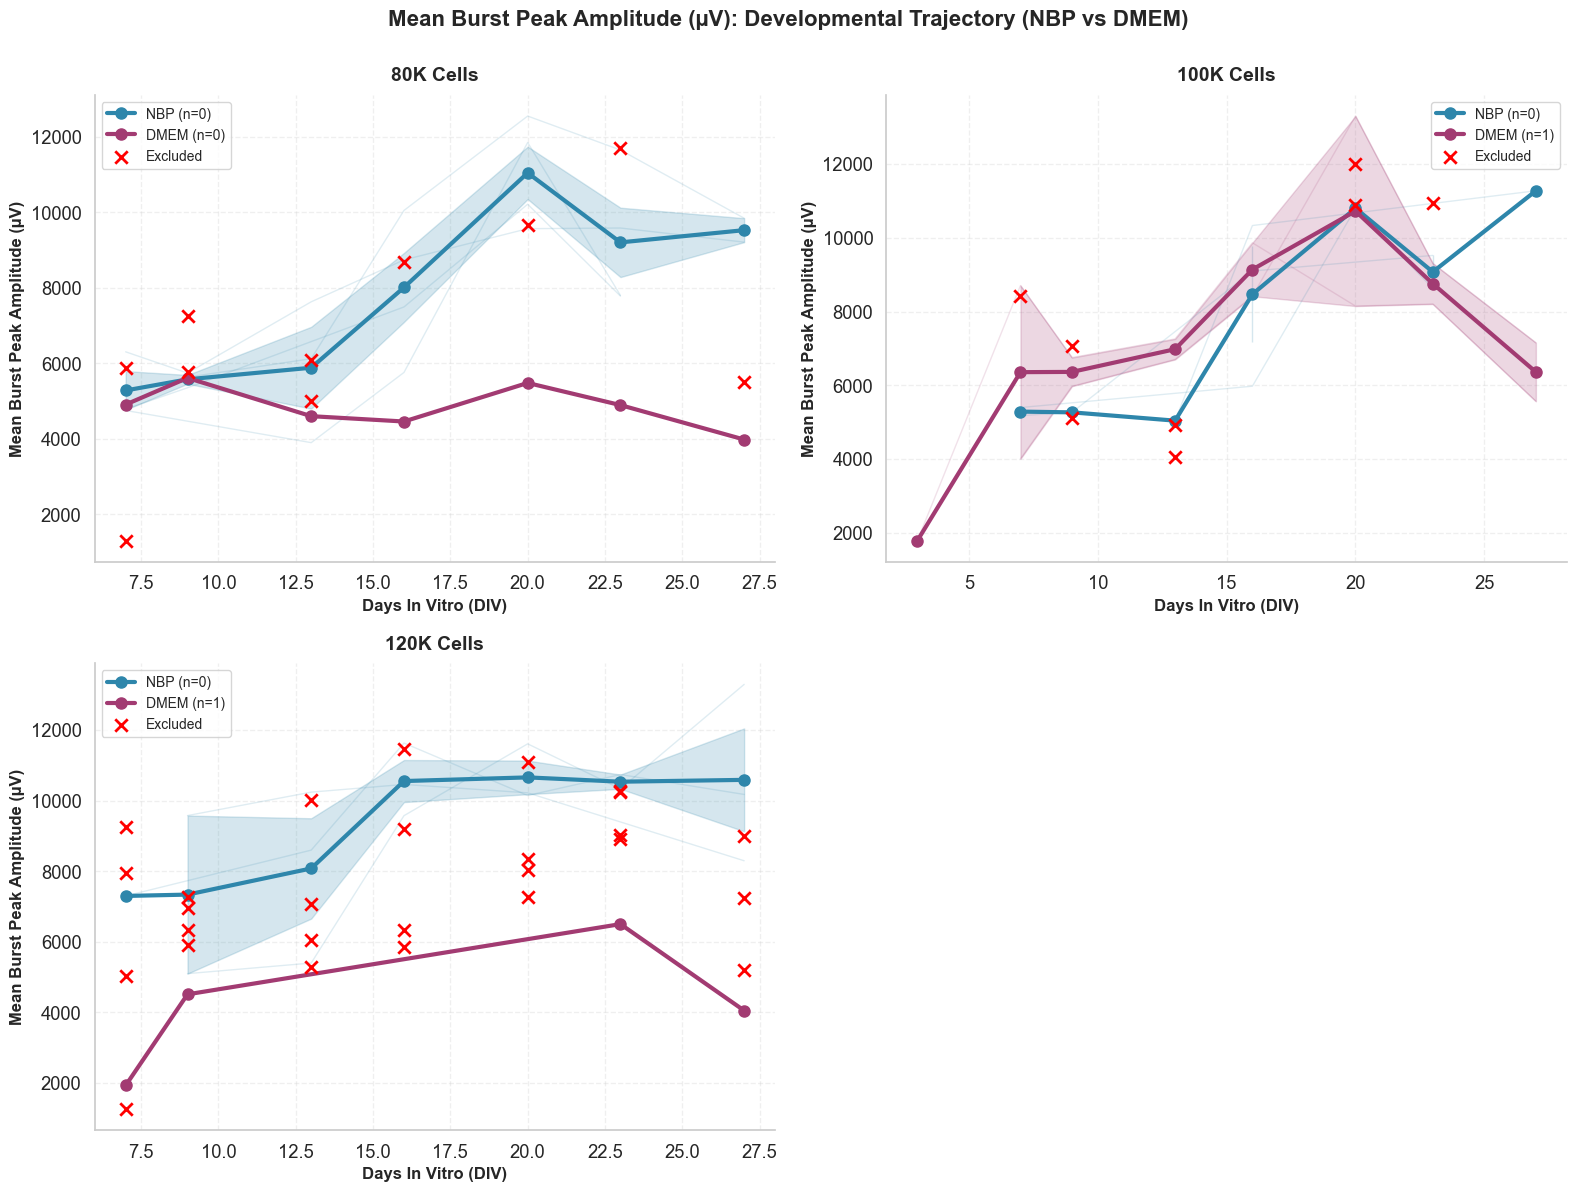

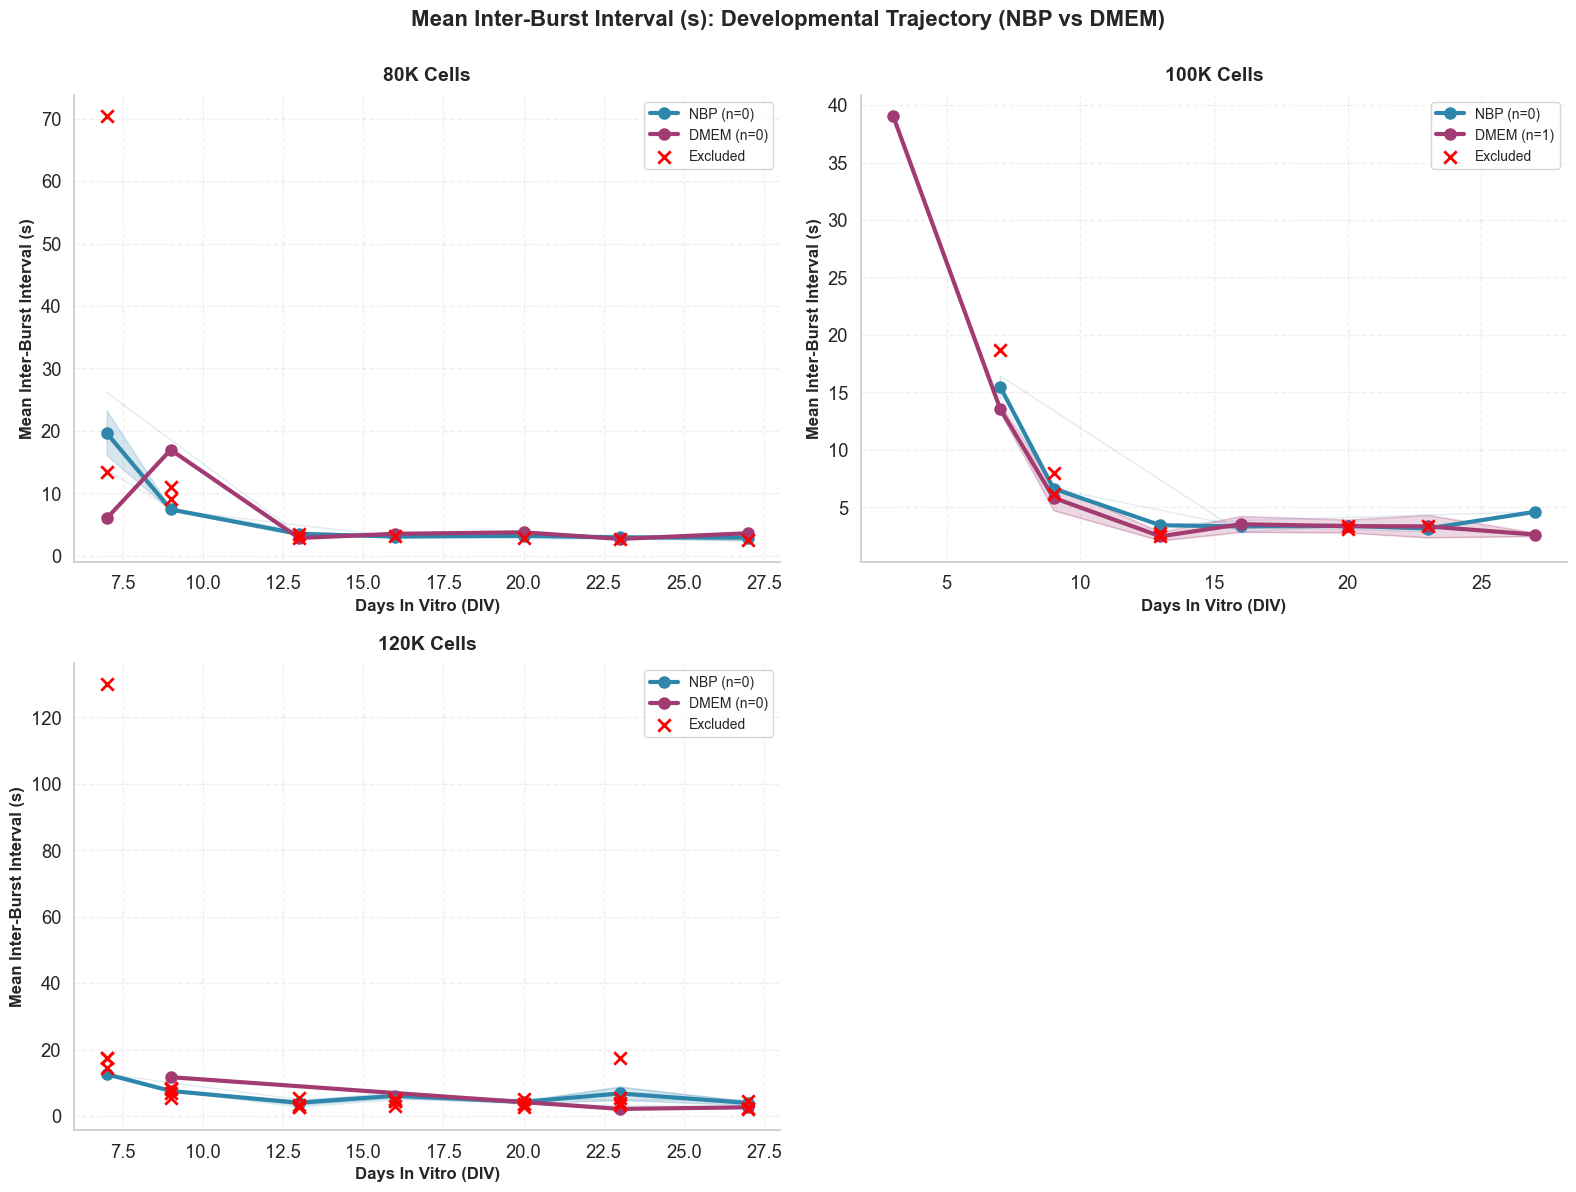

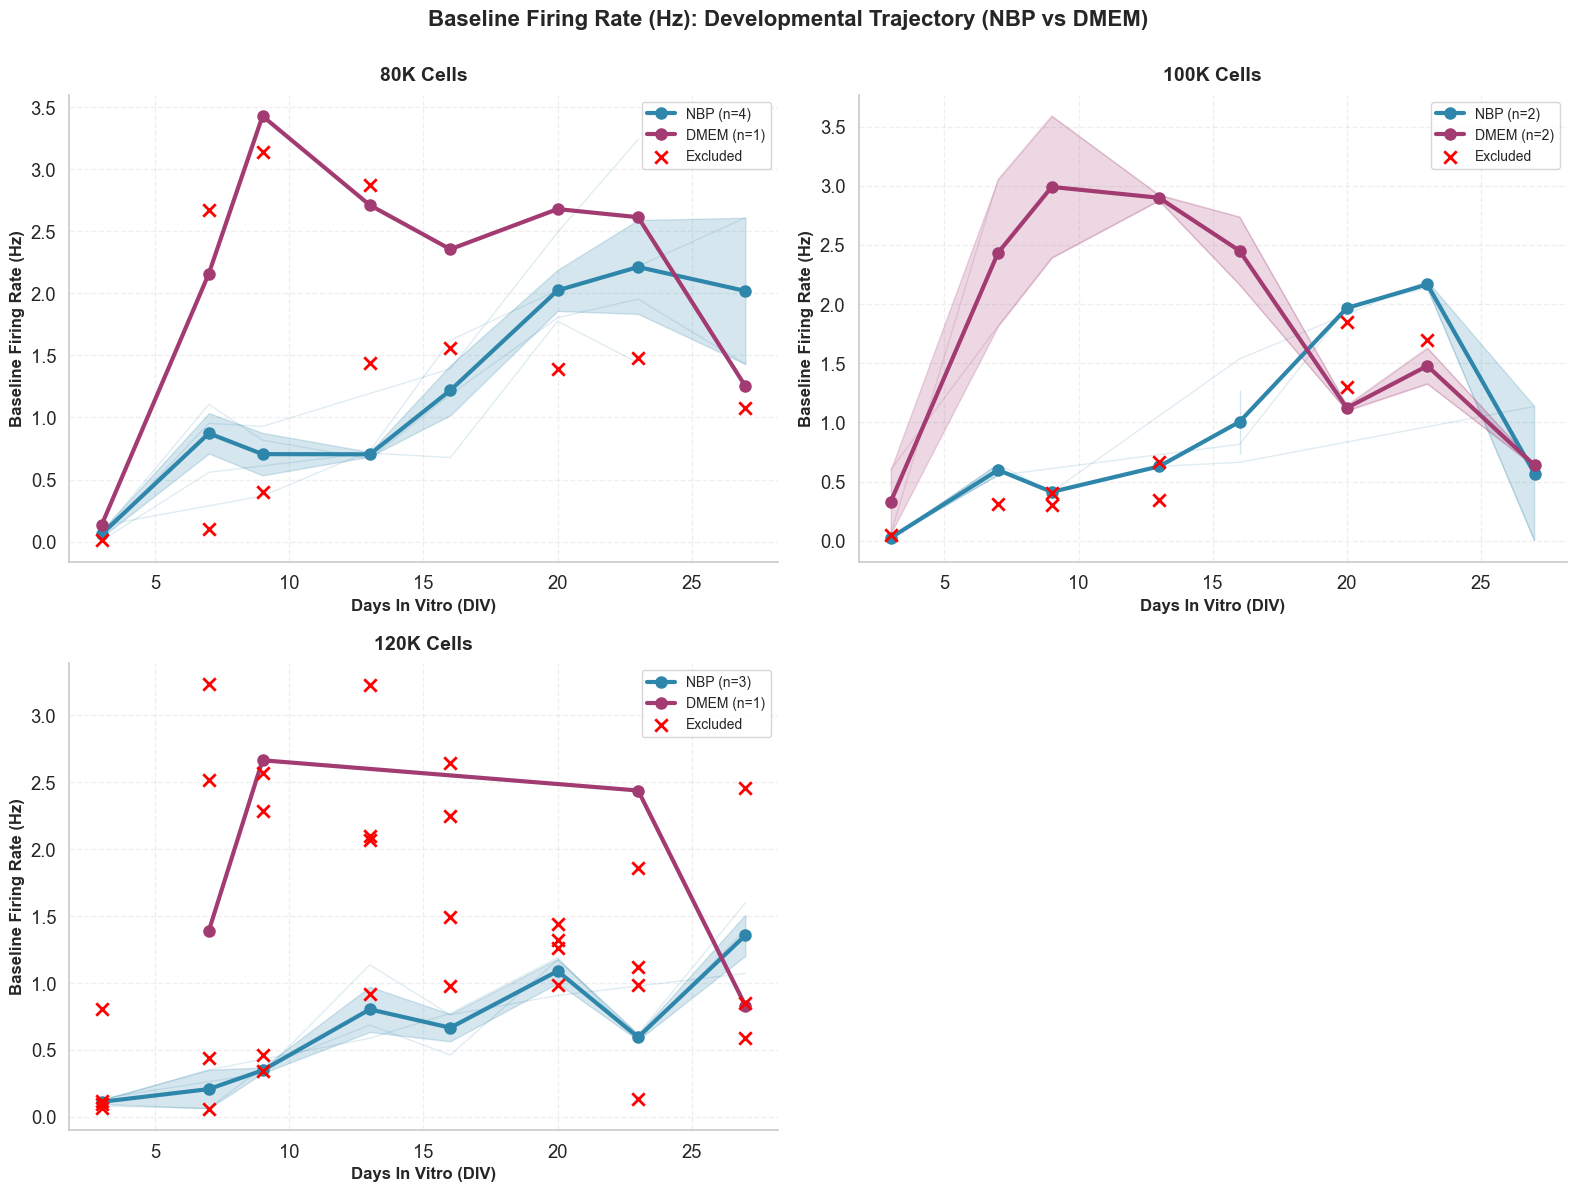

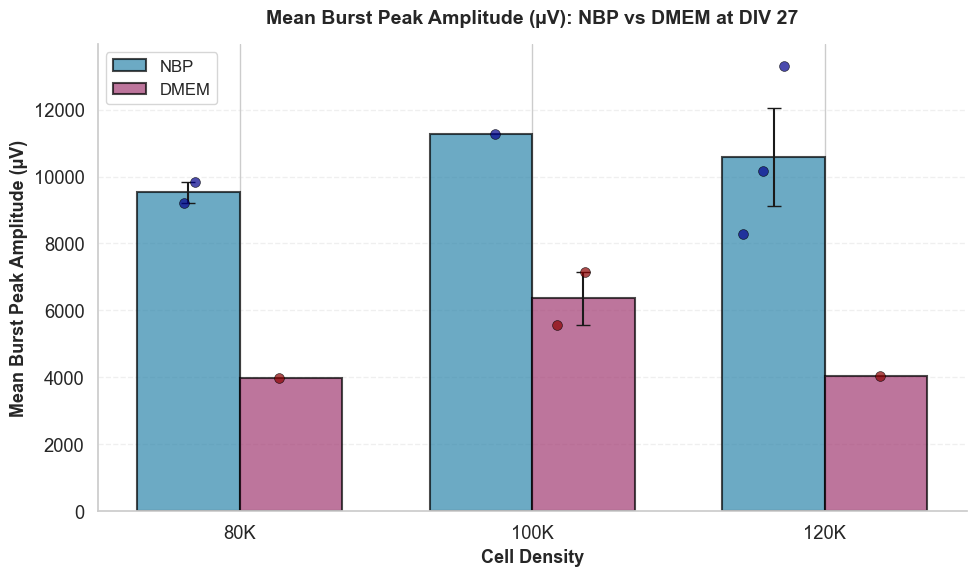

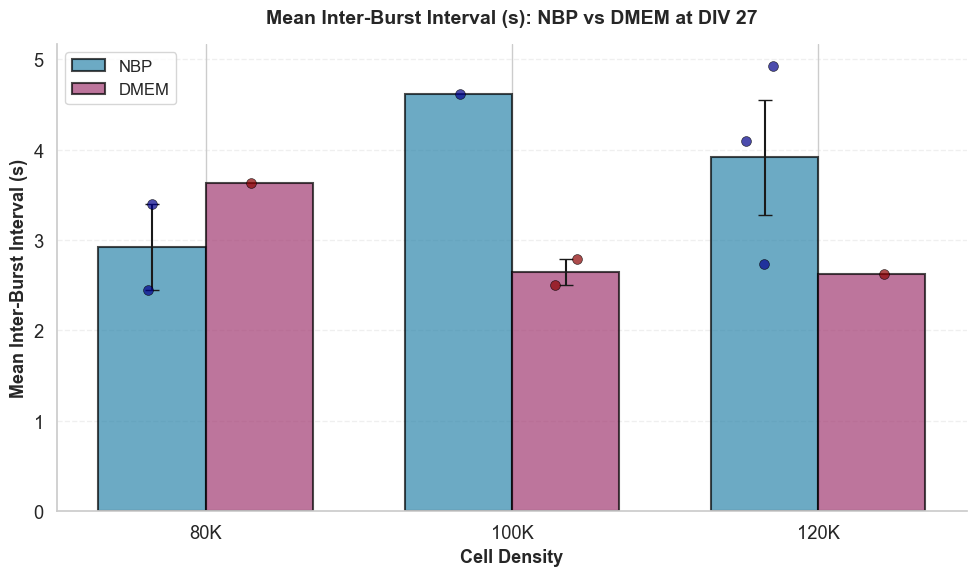

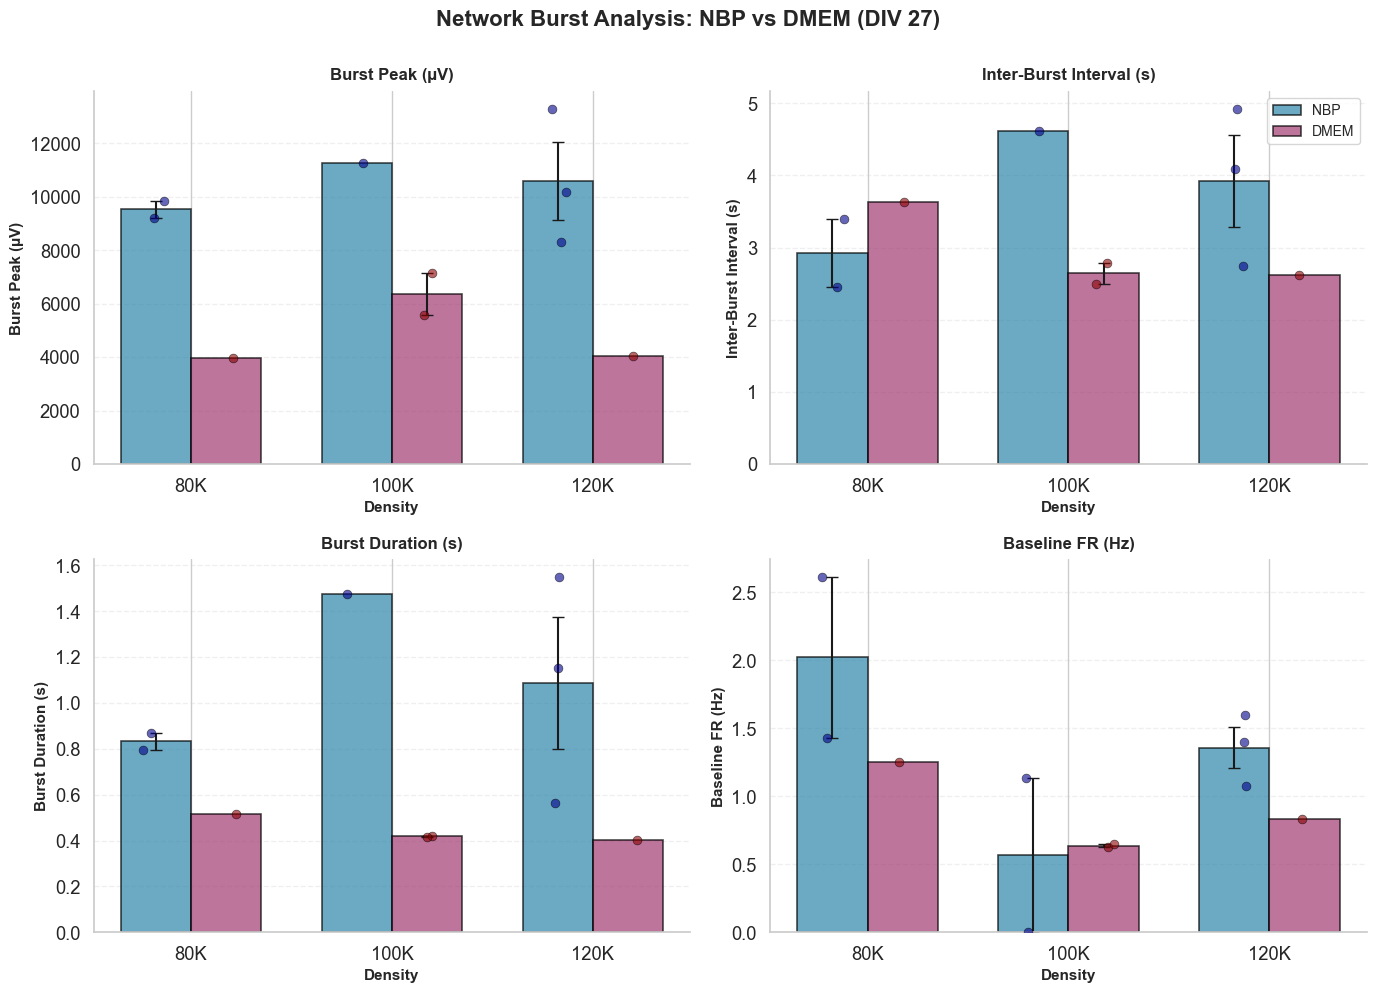


📊 STATISTICAL COMPARISONS: NBP vs DMEM

🔬 DIV 3
--------------------------------------------------------------------------------

  📌 80K Density:

  📌 100K Density:
    BaselineFiringRate        | NBP:     0.03±0.00 (n=2) | DMEM:     0.33±0.27 (n=2) | p=0.3771 ns | d=-1.13

  📌 120K Density:

🔬 DIV 7
--------------------------------------------------------------------------------

  📌 80K Density:

  📌 100K Density:
    mean_Burst_Peak_Abs       | NBP:  5287.68±109.78 (n=2) | DMEM:  6357.36±2349.17 (n=2) | p=0.6938 ns | d=-0.45
    mean_IBI                  | NBP:    15.50±0.95 (n=2) | DMEM:    13.60±0.39 (n=2) | p=0.2058 ns | d=1.85
    mean_BurstDuration        | NBP:     0.62±0.06 (n=2) | DMEM:     1.28±0.51 (n=2) | p=0.3308 ns | d=-1.27
    BaselineFiringRate        | NBP:     0.60±0.05 (n=2) | DMEM:     2.43±0.62 (n=2) | p=0.0982 ns | d=-2.95

  📌 120K Density:

🔬 DIV 9
--------------------------------------------------------------------------------

  📌 80K Density:

  📌 100K D

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, optimize
import warnings
warnings.filterwarnings('ignore')

# =====================================
# 1️⃣ DATA LOADING & PREPROCESSING
# =====================================
def load_network_data(csv_path):
    """Load network burst data and extract media type and density"""
    df = pd.read_csv(csv_path)
    
    # Extract media type (NBP or DMEM) and density from NeuronType
    df['Media'] = df['NeuronType'].str.extract(r'(NBP|DMEM)')[0]
    df['Density'] = df['NeuronType'].str.extract(r'(\d+K)')[0]
    
    # Convert to numeric
    df['DIV'] = df['DIV'].astype(int)
    df['Chip_ID'] = df['Chip_ID'].astype(str)
    df['Well'] = df['Well'].astype(str)
    
    # Create unique well identifier
    df['CHIP_WELL'] = df['Chip_ID'] + '_' + df['Well']
    
    # Drop rows with missing media or density
    df = df.dropna(subset=['Media', 'Density'])
    
    # Key network metrics to analyze
    network_metrics = [
        'mean_IBI', 'cov_IBI', 'mean_Burst_Peak', 'cov_Burst_Peak',
        'mean_Burst_Peak_Abs', 'cov_Burst_Peak_Abs', 'mean_BurstDuration',
        'cov_BurstDuration', 'BaselineFiringRate'
    ]
    
    # Convert all network metrics to numeric
    for metric in network_metrics:
        if metric in df.columns:
            df[metric] = pd.to_numeric(df[metric], errors='coerce')
    
    print(f"✅ Loaded {len(df)} measurements")
    print(f"📊 Media types: {df['Media'].unique()}")
    print(f"🔬 Densities: {sorted(df['Density'].unique())}")
    print(f"📅 DIV range: {df['DIV'].min()} - {df['DIV'].max()}")
    print(f"🧪 Chips: {df['Chip_ID'].nunique()}")
    
    # Check data availability
    print("\n📈 Data Availability per Metric:")
    for metric in network_metrics:
        if metric in df.columns:
            non_null = df[metric].notna().sum()
            print(f"  {metric}: {non_null}/{len(df)} ({non_null/len(df)*100:.1f}%)")
    
    return df


# =====================================
# 2️⃣ OUTLIER DETECTION FOR NETWORK DATA
# =====================================
def detect_network_outliers(df, metrics=None, z_thresh=3.5):
    """Detect outliers within each Media × Density × DIV group"""
    
    if metrics is None:
        metrics = ['mean_IBI', 'mean_Burst_Peak_Abs', 'mean_BurstDuration', 'BaselineFiringRate']
    
    df = df.copy()
    df['is_outlier'] = False
    
    for metric in metrics:
        if metric not in df.columns:
            continue
            
        grouped = df.groupby(['Media', 'Density', 'DIV'])
        
        for (media, density, div), group in grouped:
            vals = group[metric].dropna()
            if len(vals) < 3:
                continue
            
            # Robust median-based Z-score (Modified Z-score)
            median = np.median(vals)
            mad = np.median(np.abs(vals - median))
            
            if mad == 0:
                continue
                
            mod_z = 0.6745 * (vals - median) / mad
            outlier_mask = np.abs(mod_z) > z_thresh
            
            outlier_indices = vals.index[outlier_mask] 
            df.loc[outlier_indices, 'is_outlier'] = True
    
    print(f"\n🚨 Marked {df['is_outlier'].sum()} outliers out of {len(df)} ({df['is_outlier'].mean()*100:.1f}%)")
    return df


# =====================================
# 3️⃣ DEVELOPMENTAL TRAJECTORY FITTING
# =====================================
def logistic(x, L, k, x0):
    """Logistic growth function"""
    return L / (1 + np.exp(-k * (x - x0)))

def fit_network_trajectory(well_data, metric='mean_Burst_Peak_Abs'):
    """Fit logistic growth curve to network development"""
    try:
        x = well_data['DIV'].values
        y = well_data[metric].dropna().values
        
        if len(y) < 4 or np.all(y == 0):
            return None, np.nan
        
        x = x[:len(y)]
        
        p0 = [np.max(y), 0.3, np.median(x)]
        params, _ = optimize.curve_fit(logistic, x, y, p0=p0, maxfev=5000)
        y_pred = logistic(x, *params)
        r2 = 1 - np.sum((y - y_pred)**2) / np.sum((y - np.mean(y))**2)
        return params, r2
    except Exception:
        return None, np.nan

def detect_abnormal_network_development(df, metric='mean_Burst_Peak_Abs', r2_threshold=0.4):
    """Flag wells with poor developmental trajectory"""
    df = df.copy()
    abnormal_wells = []
    
    for well in df['CHIP_WELL'].unique():
        well_data = df[df['CHIP_WELL'] == well].sort_values('DIV')
        if len(well_data) < 4:
            continue
        
        params, r2 = fit_network_trajectory(well_data, metric)
        if np.isnan(r2) or r2 < r2_threshold:
            abnormal_wells.append(well)
    
    df['is_abnormal_trajectory'] = df['CHIP_WELL'].isin(abnormal_wells)
    print(f"🔍 Flagged {len(abnormal_wells)} wells with poor trajectory fit (R² < {r2_threshold})")
    return df


# =====================================
# 4️⃣ FILTER & MARK EXCLUSIONS
# =====================================
def mark_excluded(df):
    """Combine all flags into exclusion criteria"""
    df['to_exclude'] = df['is_outlier'] | df['is_abnormal_trajectory']
    print(f"❌ Total excluded: {df['to_exclude'].sum()}/{len(df)} ({df['to_exclude'].mean()*100:.1f}%)")
    return df


# =====================================
# 5️⃣ NETWORK BURST TRAJECTORY PLOTS
# =====================================
def plot_network_trajectory(df, metric='mean_Burst_Peak_Abs', title=None, save_path=None):
    """Plot developmental trajectory of network burst metric"""
    
    sns.set_theme(style='whitegrid', font_scale=1.2)
    
    palette = {'NBP': '#2E86AB', 'DMEM': '#A23B72'}
    densities = sorted(df['Density'].unique(), key=lambda x: int(x.replace('K', '')))
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    metric_labels = {
        'mean_IBI': 'Mean Inter-Burst Interval (s)',
        'mean_Burst_Peak_Abs': 'Mean Burst Peak Amplitude (µV)',
        'mean_BurstDuration': 'Mean Burst Duration (s)',
        'BaselineFiringRate': 'Baseline Firing Rate (Hz)',
        'cov_IBI': 'IBI Coefficient of Variation',
        'mean_Burst_Peak': 'Mean Burst Peak (normalized)'
    }
    ylabel = metric_labels.get(metric, metric)
    
    valid_df = df[~df['to_exclude']]
    excluded_df = df[df['to_exclude']]
    
    for idx, density in enumerate(densities):
        if idx >= len(axes):
            break
        
        ax = axes[idx]
        density_data = valid_df[valid_df['Density'] == density]
        excluded_density = excluded_df[excluded_df['Density'] == density]
        
        # Plot individual wells (light)
        for media in ['NBP', 'DMEM']:
            media_data = density_data[density_data['Media'] == media]
            for well in media_data['CHIP_WELL'].unique():
                well_data = media_data[media_data['CHIP_WELL'] == well].sort_values('DIV')
                ax.plot(well_data['DIV'], well_data[metric], 
                       alpha=0.15, color=palette[media], linewidth=1)
        
        # Plot mean trajectories with SEM
        for media in ['NBP', 'DMEM']:
            media_data = density_data[density_data['Media'] == media]
            stats_df = media_data.groupby('DIV')[metric].agg(['mean', 'sem', 'count'])
            divs = stats_df.index.values
            means = stats_df['mean'].values
            sems = stats_df['sem'].values
            
            ax.plot(divs, means, '-o', lw=3, markersize=8,
                   color=palette[media], label=f"{media} (n={stats_df['count'].iloc[0]})")
            ax.fill_between(divs, means - sems, means + sems, 
                           color=palette[media], alpha=0.2)
        
        # Mark excluded points
        if len(excluded_density) > 0:
            ax.scatter(excluded_density['DIV'], excluded_density[metric],
                      color='red', marker='x', s=80, linewidth=2,
                      label='Excluded', zorder=10)
        
        ax.set_xlabel('Days In Vitro (DIV)', fontsize=12, weight='bold')
        ax.set_ylabel(ylabel, fontsize=12, weight='bold')
        ax.set_title(f'{density} Cells', fontsize=14, weight='bold', pad=10)
        ax.legend(frameon=True, fontsize=10, loc='best')
        for spine in ['top', 'bottom', 'left', 'right']:
            ax.spines[spine].set_visible(True)
            ax.spines[spine].set_color('black')
            ax.spines[spine].set_linewidth(1.5)

    # Hide extra subplots
    for idx in range(len(densities), len(axes)):
        axes[idx].set_visible(False)
    
    if title is None:
        title = f'{ylabel}: Developmental Trajectory (NBP vs DMEM)'
    fig.suptitle(title, fontsize=16, weight='bold', y=0.995)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


# =====================================
# 6️⃣ BAR PLOT COMPARISON
# =====================================
def plot_network_bars(df, metric='mean_Burst_Peak_Abs', specific_div=None, save_path=None):
    """Bar plot comparing NBP vs DMEM for network metrics"""
    
    if specific_div is not None:
        df_plot = df[df['DIV'] == specific_div].copy()
        title_suffix = f'at DIV {specific_div}'
    else:
        # Use latest DIV
        latest_div = df['DIV'].max()
        df_plot = df[df['DIV'] == latest_div].copy()
        title_suffix = f'at DIV {latest_div}'
    
    valid_df = df_plot[~df_plot['to_exclude']]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    colors = {'NBP': '#2E86AB', 'DMEM': '#A23B72'}
    densities = sorted(valid_df['Density'].unique(), key=lambda x: int(x.replace('K', '')))
    
    x_pos = np.arange(len(densities))
    bar_width = 0.35
    
    nbp_means = []
    nbp_sems = []
    dmem_means = []
    dmem_sems = []
    
    for density in densities:
        nbp_vals = valid_df[(valid_df['Media'] == 'NBP') & 
                            (valid_df['Density'] == density)][metric].dropna()
        dmem_vals = valid_df[(valid_df['Media'] == 'DMEM') & 
                             (valid_df['Density'] == density)][metric].dropna()
        
        nbp_means.append(nbp_vals.mean() if len(nbp_vals) > 0 else 0)
        nbp_sems.append(nbp_vals.sem() if len(nbp_vals) > 0 else 0)
        dmem_means.append(dmem_vals.mean() if len(dmem_vals) > 0 else 0)
        dmem_sems.append(dmem_vals.sem() if len(dmem_vals) > 0 else 0)
    
    # Plot bars
    ax.bar(x_pos - bar_width/2, nbp_means, bar_width, 
           yerr=nbp_sems, label='NBP', color=colors['NBP'], 
           alpha=0.7, capsize=5, edgecolor='black', linewidth=1.5)
    ax.bar(x_pos + bar_width/2, dmem_means, bar_width,
           yerr=dmem_sems, label='DMEM', color=colors['DMEM'],
           alpha=0.7, capsize=5, edgecolor='black', linewidth=1.5)
    
    # Overlay individual points
    for i, density in enumerate(densities):
        nbp_vals = valid_df[(valid_df['Media'] == 'NBP') & 
                            (valid_df['Density'] == density)][metric].dropna()
        dmem_vals = valid_df[(valid_df['Media'] == 'DMEM') & 
                             (valid_df['Density'] == density)][metric].dropna()
        
        if len(nbp_vals) > 0:
            x_jitter = np.random.normal(i - bar_width/2, 0.04, len(nbp_vals))
            ax.scatter(x_jitter, nbp_vals, color='darkblue', 
                      s=50, alpha=0.7, edgecolor='black', linewidth=0.5, zorder=3)
        
        if len(dmem_vals) > 0:
            x_jitter = np.random.normal(i + bar_width/2, 0.04, len(dmem_vals))
            ax.scatter(x_jitter, dmem_vals, color='darkred',
                      s=50, alpha=0.7, edgecolor='black', linewidth=0.5, zorder=3)
    
    metric_labels = {
        'mean_IBI': 'Mean Inter-Burst Interval (s)',
        'mean_Burst_Peak_Abs': 'Mean Burst Peak Amplitude (µV)',
        'mean_BurstDuration': 'Mean Burst Duration (s)',
        'BaselineFiringRate': 'Baseline Firing Rate (Hz)'
    }
    
    ax.set_xlabel('Cell Density', fontsize=13, weight='bold')
    ax.set_ylabel(metric_labels.get(metric, metric), fontsize=13, weight='bold')
    ax.set_title(f'{metric_labels.get(metric, metric)}: NBP vs DMEM {title_suffix}', 
                 fontsize=14, weight='bold', pad=15)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(densities)
    ax.legend(frameon=True, fontsize=12, loc='upper left')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


# =====================================
# 7️⃣ MULTI-METRIC DASHBOARD
# =====================================
def plot_network_dashboard(df, specific_div=None, save_path=None):
    """Comprehensive dashboard of key network metrics"""
    
    if specific_div is not None:
        df_plot = df[df['DIV'] == specific_div].copy()
        title_suffix = f'DIV {specific_div}'
    else:
        latest_div = df['DIV'].max()
        df_plot = df[df['DIV'] == latest_div].copy()
        title_suffix = f'DIV {latest_div}'
    
    valid_df = df_plot[~df_plot['to_exclude']]
    
    metrics = ['mean_Burst_Peak_Abs', 'mean_IBI', 'mean_BurstDuration', 'BaselineFiringRate']
    metric_labels = {
        'mean_Burst_Peak_Abs': 'Burst Peak (µV)',
        'mean_IBI': 'Inter-Burst Interval (s)',
        'mean_BurstDuration': 'Burst Duration (s)',
        'BaselineFiringRate': 'Baseline FR (Hz)'
    }
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    colors = {'NBP': '#2E86AB', 'DMEM': '#A23B72'}
    densities = sorted(valid_df['Density'].unique(), key=lambda x: int(x.replace('K', '')))
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx]
        x_pos = np.arange(len(densities))
        bar_width = 0.35
        
        nbp_means, nbp_sems = [], []
        dmem_means, dmem_sems = [], []
        
        for density in densities:
            nbp_vals = valid_df[(valid_df['Media'] == 'NBP') & 
                                (valid_df['Density'] == density)][metric].dropna()
            dmem_vals = valid_df[(valid_df['Media'] == 'DMEM') & 
                                 (valid_df['Density'] == density)][metric].dropna()
            
            nbp_means.append(nbp_vals.mean() if len(nbp_vals) > 0 else 0)
            nbp_sems.append(nbp_vals.sem() if len(nbp_vals) > 0 else 0)
            dmem_means.append(dmem_vals.mean() if len(dmem_vals) > 0 else 0)
            dmem_sems.append(dmem_vals.sem() if len(dmem_vals) > 0 else 0)
        
        # Bars
        ax.bar(x_pos - bar_width/2, nbp_means, bar_width, 
               yerr=nbp_sems, label='NBP', color=colors['NBP'], 
               alpha=0.7, capsize=4, edgecolor='black', linewidth=1.2)
        ax.bar(x_pos + bar_width/2, dmem_means, bar_width,
               yerr=dmem_sems, label='DMEM', color=colors['DMEM'],
               alpha=0.7, capsize=4, edgecolor='black', linewidth=1.2)
        
        # Points
        for i, density in enumerate(densities):
            nbp_vals = valid_df[(valid_df['Media'] == 'NBP') & 
                                (valid_df['Density'] == density)][metric].dropna()
            dmem_vals = valid_df[(valid_df['Media'] == 'DMEM') & 
                                 (valid_df['Density'] == density)][metric].dropna()
            
            if len(nbp_vals) > 0:
                x_jitter = np.random.normal(i - bar_width/2, 0.03, len(nbp_vals))
                ax.scatter(x_jitter, nbp_vals, color='darkblue', 
                          s=40, alpha=0.6, edgecolor='black', linewidth=0.5, zorder=3)
            
            if len(dmem_vals) > 0:
                x_jitter = np.random.normal(i + bar_width/2, 0.03, len(dmem_vals))
                ax.scatter(x_jitter, dmem_vals, color='darkred',
                          s=40, alpha=0.6, edgecolor='black', linewidth=0.5, zorder=3)
        
        ax.set_xlabel('Density', fontsize=11, weight='bold')
        ax.set_ylabel(metric_labels[metric], fontsize=11, weight='bold')
        ax.set_title(metric_labels[metric], fontsize=12, weight='bold', pad=8)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(densities)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        if idx == 1:
            ax.legend(frameon=True, fontsize=10, loc='upper right')
    
    fig.suptitle(f'Network Burst Analysis: NBP vs DMEM ({title_suffix})', 
                 fontsize=16, weight='bold', y=0.995)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


# =====================================
# 8️⃣ STATISTICAL COMPARISON
# =====================================
def perform_statistical_tests(df, metrics=None):
    """Perform statistical comparisons between NBP and DMEM"""
    
    if metrics is None:
        metrics = ['mean_Burst_Peak_Abs', 'mean_IBI', 'mean_BurstDuration', 'BaselineFiringRate']
    
    valid_df = df[~df['to_exclude']]
    
    print("\n" + "="*80)
    print("📊 STATISTICAL COMPARISONS: NBP vs DMEM")
    print("="*80)
    
    for div in sorted(valid_df['DIV'].unique()):
        print(f"\n🔬 DIV {div}")
        print("-" * 80)
        div_data = valid_df[valid_df['DIV'] == div]
        
        for density in sorted(div_data['Density'].unique(), key=lambda x: int(x.replace('K', ''))):
            print(f"\n  📌 {density} Density:")
            density_data = div_data[div_data['Density'] == density]
            
            for metric in metrics:
                nbp_vals = density_data[density_data['Media'] == 'NBP'][metric].dropna()
                dmem_vals = density_data[density_data['Media'] == 'DMEM'][metric].dropna()
                
                if len(nbp_vals) < 2 or len(dmem_vals) < 2:
                    continue
                
                # T-test
                t_stat, p_val = stats.ttest_ind(nbp_vals, dmem_vals)
                
                # Effect size (Cohen's d)
                pooled_std = np.sqrt(((len(nbp_vals)-1)*nbp_vals.std()**2 + 
                                     (len(dmem_vals)-1)*dmem_vals.std()**2) / 
                                    (len(nbp_vals) + len(dmem_vals) - 2))
                cohens_d = (nbp_vals.mean() - dmem_vals.mean()) / pooled_std if pooled_std > 0 else 0
                
                sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
                
                print(f"    {metric:25s} | NBP: {nbp_vals.mean():8.2f}±{nbp_vals.sem():.2f} (n={len(nbp_vals)}) | "
                      f"DMEM: {dmem_vals.mean():8.2f}±{dmem_vals.sem():.2f} (n={len(dmem_vals)}) | "
                      f"p={p_val:.4f} {sig} | d={cohens_d:.2f}")


# =====================================
# 9️⃣ MAIN PIPELINE
# =====================================
if __name__ == "__main__":
    # Load data
    csv_path = "/mnt/disk15tb/ammara/AR_Media Density_T3_07012025_All Files/Network_outputs/Compiled_Networks.csv"
    
    df = load_network_data(csv_path)
    
    # Quality control
    df = detect_network_outliers(df)
    df = detect_abnormal_network_development(df)
    df = mark_excluded(df)
    
    output_dir = "/mnt/disk15tb/shruti/MediaDensityT3Outputs/NetworkOutputs_v2"
    import os
    os.makedirs(output_dir, exist_ok=True)
    # Generate plots
    print("\n🎨 Generating visualizations...")
    
    # 1. Trajectory plots
    plot_network_trajectory(df, metric='mean_Burst_Peak_Abs',
                           save_path=f'{output_dir}/network_burst_amplitude_trajectory.png')
    
    plot_network_trajectory(df, metric='mean_IBI',
                           save_path=f'{output_dir}/network_IBI_trajectory.png')
    
    plot_network_trajectory(df, metric='BaselineFiringRate',
                           save_path=f'{output_dir}/network_baseline_FR_trajectory.png')
    
    # 2. Bar plots at latest DIV
    latest_div = df['DIV'].max()
    
    plot_network_bars(df, metric='mean_Burst_Peak_Abs', specific_div=latest_div,
                     save_path=f'{output_dir}/network_burst_amplitude_DIV{latest_div}.png')
    
    plot_network_bars(df, metric='mean_IBI', specific_div=latest_div,
                     save_path=f'{output_dir}/network_IBI_DIV{latest_div}.png')
    
    # 3. Dashboard
    plot_network_dashboard(df, specific_div=latest_div,
                          save_path=f'{output_dir}/network_dashboard_DIV{latest_div}.png')
    
    # 4. Statistical analysis
    perform_statistical_tests(df)
    
    # 5. Save filtered data
    df[~df['to_exclude']].to_csv(f'{output_dir}/filtered_network_data.csv', index=False)
    df[df['to_exclude']].to_csv(f'{output_dir}/excluded_network_data.csv', index=False)
    
    print("\n✅ Analysis complete! All figures and data saved.")

In [4]:
import h5py

# Define the path to your h5 file
h5_file_path = '/mnt/disk15tb/ammara/AR_Media Density_T2_04142025_All Files/Media Density_T2_04142025_AR/Media_Density_Experiment_T2_04142025_AR/250421/M08024/AxonTracking/000031/data.raw.h5'

# Open the file in read mode
with h5py.File(h5_file_path, 'r') as f:
    # Print the top-level groups in the file
    print(f"Top-level groups/datasets: {list(f.keys())}")
    
    # Access a dataset by name (replace 'dataset_name' with actual)
    # dataset = f['dataset_name']
    # Read the entire dataset into a numpy array
    # data_array = dataset[()]
    # print(data_array)


Top-level groups/datasets: ['assay', 'bits', 'data_store', 'environment', 'hdf_version', 'mxw_version', 'notes', 'recordings', 'version', 'wellplate', 'wells']


In [6]:
import h5py

with h5py.File(h5_file_path, 'r') as f:
    for group_name in f.keys():
        print(f"Contents of group '{group_name}':")
        group = f[group_name]
        print(list(group.keys()))


Contents of group 'assay':
['inputs', 'run_id', 'script_id']
Contents of group 'bits':
[]
Contents of group 'data_store':
['data0000', 'data0001', 'data0002', 'data0003', 'data0004', 'data0005', 'data0006', 'data0007', 'data0008', 'data0009', 'data0010', 'data0011', 'data0012', 'data0013', 'data0014', 'data0015', 'data0016', 'data0017', 'data0018', 'data0019', 'data0020', 'data0021', 'data0022', 'data0023', 'data0024', 'data0025', 'data0026', 'data0027', 'data0028', 'data0029', 'data0030', 'data0031', 'data0032', 'data0033', 'data0034', 'data0035', 'data0036', 'data0037', 'data0038', 'data0039', 'data0040', 'data0041', 'data0042', 'data0043', 'data0044', 'data0045', 'data0046', 'data0047', 'data0048', 'data0049', 'data0050', 'data0051', 'data0052', 'data0053', 'data0054', 'data0055', 'data0056', 'data0057', 'data0058', 'data0059', 'data0060', 'data0061', 'data0062', 'data0063', 'data0064', 'data0065', 'data0066', 'data0067', 'data0068', 'data0069', 'data0070', 'data0071', 'data0072', '

AttributeError: 'Dataset' object has no attribute 'keys'

In [5]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Open HDF5 file
with h5py.File(h5_file_path, 'r') as f:
    # Example: assuming electrode locations and signal amplitude dataset names
    electrode_coords = f['electrode_coords'][()]  # shape (num_electrodes, 2)
    signal_amplitudes = f['signal_amplitudes'][()]  # shape (num_electrodes,)

# Scatter plot footprint
plt.scatter(electrode_coords[:,0], electrode_coords[:,1], c=signal_amplitudes, cmap='viridis')
plt.colorbar(label='Signal amplitude')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Electrode Footprint Heatmap')
plt.show()


KeyError: "Unable to synchronously open object (object 'electrode_coords' doesn't exist)"

In [2]:
pip install spikeinterface.toolkit 


ERROR: Could not find a version that satisfies the requirement spikeinterface.toolkit (from versions: none)
ERROR: No matching distribution found for spikeinterface.toolkit

[notice] A new release of pip is available: 24.1.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import matplotlib.pyplot as plt

recording = se.read_maxwell(h5_file_path, stream_id='well0004')

# Get metadata
channel_ids = recording.get_channel_ids()
fs = recording.get_sampling_frequency()
locs = recording.get_channel_locations()

# Bandpass filter the recording
filtered_recording = spre.bandpass_filter(recording, freq_min=300, freq_max=4500)

# Get traces from first 10 channels, first second
start_frame = 0
end_frame = int(fs)
traces = filtered_recording.get_traces(channel_ids=channel_ids[:10], start_frame=start_frame, end_frame=end_frame)

# Plot signal traces
time_axis = (np.arange(end_frame - start_frame) / fs) * 1000  # milliseconds
plt.figure(figsize=(10, 6))
for i, ch_id in enumerate(channel_ids[:10]):
    plt.plot(time_axis, traces[i] + i*50, label=f'Ch {ch_id}')  # offset for visibility

plt.xlabel('Time (ms)')
plt.ylabel('Voltage (offset for each channel)')
plt.title('Filtered Signal Traces (First 10 Channels)')
plt.legend()
plt.show()

# Plot spatial footprint of mean amplitude during this period
mean_amplitude = traces.mean(axis=1)
plt.scatter(locs[:, 0], locs[:, 1], c=mean_amplitude, cmap='inferno')
plt.colorbar(label='Mean signal amplitude')
plt.title('Spatial Electrode Footprint')
plt.xlabel('X location')
plt.ylabel('Y location')
plt.show()


ValueError: Detected multiple recordings. Please select a single recording using the `rec_name` parameter. Possible rec_name ['rec0000', 'rec0001', 'rec0002', 'rec0003', 'rec0004', 'rec0005', 'rec0006', 'rec0007', 'rec0008', 'rec0009', 'rec0010', 'rec0011', 'rec0012', 'rec0013', 'rec0014', 'rec0015', 'rec0016', 'rec0017', 'rec0018', 'rec0019', 'rec0020']